# <font color=blue> *Text Data Analysis Notebook* </font>
Book Recommender System<br>
Sabrina Ruiz

# Introduction
In this notebook, I will optimize the text vectorization and processing for the `review` column of my cleaned data. I will create a custom tokenizer to best fit my data set. Lastly, I will create a content-based recommender system that will recommend books based on a written review.

#### ***Why a review-based recommender?***
Ultimately, I plan to productionalize this project for my current workplace, and elementary school. With limited access to live data, I plan to create a system in which a child can input their review of a book they liked, and get a selection of books to read next.

# Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import nltk
stemmer = nltk.stem.PorterStemmer()
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity

# libraries that may be used in the future
    #from sklearn.compose import ColumnTransformer
    #from imblearn.under_sampling import RandomUnderSampler
    #from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# setting a color palette for Seaborn visualizations
bright_palette = sns.set_palette(palette = "bright")

#other visual standards
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/My Drive/combined_book_data_cut.csv', index_col=0)
data.head() # takes about 60 secs

In [16]:
data.shape

(2616533, 10)

# Exploring Sentiment
for the purposes of exploring general sentiment, I will convert the `review_score` to a binary representing *positive* and *negative* sentiment. Next, I will explore the possibility of a multiclass classifier. A multiclass system would perhaps addresess any issues brought about with a simple binary.

For the purpose of this project, I will set ***negative*** sentiment to be scores of 3 and below, and ***positive*** sentiment to be scores 4 & 5. Ultimately, I wish to train my final book recommender model on elementary school book data for children to use. In my experience, children tend to be more polar in the likes and dislikes.

#### "Positive" & "Negative" Sentiment

In [17]:
#creating a new df, binary sentiment
pos_neg_df = data.copy()
pos_neg_df.head(2)

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography


In [ ]:

pos_neg_df['review_score'] = np.where(pos_neg_df['review_score'] > 3, 1, 0)
# change column name to reflect changes
pos_neg_df.rename(columns={"review_score": "sentiment"}, inplace=True)
pos_neg_df.head()

,Id,Title,User_id,profileName,sentiment,review_summary,review,authors,publishedDate,categories
0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",1,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels
1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,1,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography
2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,1,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography
3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",1,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography
4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",1,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography


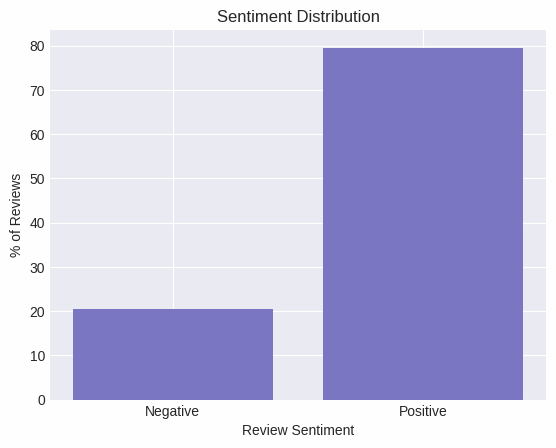

Class imbalance: [0.2 0.8]


In [ ]:
values, counts = np.unique(pos_neg_df['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.title("Sentiment Distribution")
plt.bar(["Negative", "Positive"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Sentiment')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

This is quite inbalanced! To be more precise, [Google](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) would classify this as a "moderate" degree of imbalance.
#### MultiClass Sentiment
Let's explore having a three-class division of sentiment, with a score of 3 being "neutral."

In [ ]:
#create new df for 3 classes
three_class_df = data.copy()
#divide rating to 3
three_class_df['sentiment'] = np.select([three_class_df['review_score'] == 1,
                                         three_class_df['review_score'] == 2,
                                         three_class_df['review_score'] == 3,
                                         three_class_df['review_score'] == 4,
                                         three_class_df['review_score'] == 5],
                                          [0,0,1,1,2], default=np.nan)
three_class_df

,Unnamed: 0,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories,sentiment
0,0,1882931173,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,Julie Strain,1996.0,Comics & Graphic Novels,1.0
1,1,0826414346,Dr. Seuss: American Icon,A30TK6U7DNS82R,Kevin Killian,5,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel,2005.0,Biography & Autobiography,2.0
2,2,0826414346,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,John Granger,5,Essential for every personal and Public Library,"If people become the books they read and if ""t...",Philip Nel,2005.0,Biography & Autobiography,2.0
3,3,0826414346,Dr. Seuss: American Icon,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Philip Nel,2005.0,Biography & Autobiography,1.0
4,4,0826414346,Dr. Seuss: American Icon,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,Philip Nel,2005.0,Biography & Autobiography,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2974297,2999787,B000NSLVCU,The Idea of History,unknown,unknown,4,Difficult,"This is an extremely difficult book to digest,...",R. G. Collingwood,2018.0,History,1.0
2974298,2999788,B000NSLVCU,The Idea of History,A1SMUB9ASL5L9Y,jafrank,4,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...,R. G. Collingwood,2018.0,History,1.0
2974299,2999789,B000NSLVCU,The Idea of History,A2AQMEKZKK5EE4,"L. L. Poulos ""Muslim Mom""",4,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i...",R. G. Collingwood,2018.0,History,1.0
2974300,2999790,B000NSLVCU,The Idea of History,A18SQGYBKS852K,"Julia A. Klein ""knitting rat""",5,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,...",R. G. Collingwood,2018.0,History,2.0


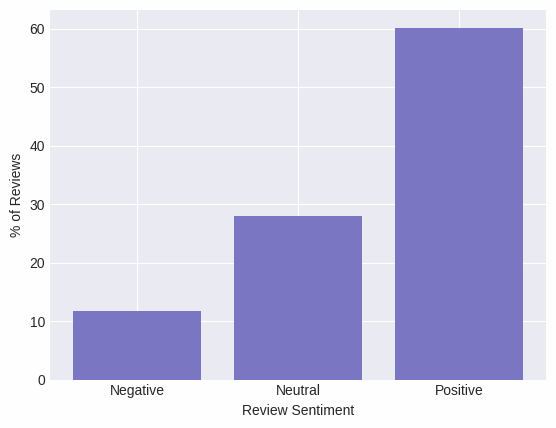

Class imbalance: [0.12 0.28 0.6 ]


In [ ]:
values, counts = np.unique(three_class_df['sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["Negative", "Neutral","Positive"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Sentiment')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

This is still pretty biased, and not an accurate division between the three classifications.

#### Addressing Data Inbalance

I will take the following steps to address the data inbalance:


1.   **Do nothing:** I will see if the imbalance affects results. If issues arise, I will move on to step 2.
2.   **Undersampling** I will attempt removing reviews of the majority class, "positive sentiment." Seeing as this is a large dataset, for the sake of computing power and efficiency, I decided "oversampling" would be less ideal.

Any steps taken will be during or after the train-test split so as to have the test data remain as real as possible.



# Preprocessing

For the sake of processing power, only a sample of the data as shown in the code below, will be selected. This number was increased as much as possible using Google Colab's CPU. Seeing as my terminal shuts down as soon as each Vectorizer is completed, I will elect to save the sparse matrix outcome to a dataframe and output it as a csv for ease of access.

In [27]:
#Which is my final working dataframe?
modeling_df = data.sample(n=100000, random_state=18)
modeling_df

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories
2476676,096406054X,Mouse Tales: A Behind-the-Ears Look at Disneyl...,A89Y6WZKEP069,Jewelz- Theo's Mom,2,Caution: You may lose a bit of the magic....,This is a very well written book about the inn...,David Koenig,2005.0,Biography & Autobiography
2941482,B000MC7FBS,WAR AS I KNEW IT.,A3KFFGZCE3R836,Steven Patton,5,War as I knew it.,Fantastic! Wish we had a leader such as him to...,George Smith Patton,1980.0,Generals
141151,B000KIT9U4,The Shelters Of Stone - The Earth's Children S...,A5XSPTAK24CDZ,HannahR,1,Puh-leese...,"...hindsight being 20/20, I would have wished ...",Jean M. Auel,2002.0,Fiction
2153415,B000KAFUP0,The Clear and Simple Thesaurus Dictionary,AFHYEO3Y1IIDD,maximum verbosity,5,"Different than expected, but still happy",I thought this book was for a little bit young...,"Harriet Wittels', 'Joan Greisman",2006.0,Juvenile Nonfiction
2853977,1590591518,Learn to Program with Visual Basic 6,A12KQ3ZZO00ZBX,K. Schaller,4,Effective teaching technique,Mr. Smiley uses the approach of solving real-w...,John Smiley,2003.0,uncategorized
...,...,...,...,...,...,...,...,...,...,...
2173289,1413715230,"Sunny, Ward of the State: Calamity Strikes a F...",A1X0J509VGPTKA,SwitzerlandBob,5,This book brought back memories for my Dad,My Dad Bob Richartz grew up at Leake & Watts i...,Sonja Heinze Coryat,2004.0,uncategorized
1677085,0786282029,S Is For Silence,AGJR0N9LE9MYU,Vidagray,5,"""S"" is for Silence",Sue Grafton writes a good mystery. I love them...,Sue Grafton,2009.0,Fiction
871374,B0006E2W9M,The grapes of wrath (The Collector's library o...,unknown,unknown,5,"Get off Steinbeck, he's the the man, ...",The Grapes of Wrath was a great book filled wi...,Library of Congress,1981.0,Monographic series
2461625,1570424713,Selling the Invisible: A Field Guide to Modern...,AFUSHCALNDGJJ,"Leonard ""Leonard""",5,"An unassuming charming book, I loved it!",I started reading it and couldn't put it down....,Harry Beckwith,2000.0,Business & Economics


In [6]:
X = modeling_df[['Title','User_id', 'review']]
y = modeling_df['review_score']

In [7]:
# splitting our data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=18, stratify=y)
# 10 secs

In [11]:
X_train

,Title,User_id,review
645914,Looking Good (Smart Talk Series),unknown,"Although the information is a bit dated, (I'd ..."
1464908,The Godfather,unknown,I teach this book in the same course I teach H...
1093596,The Innocent Man: Murder and Injustice in a Sm...,A39DB8DMBS1JXQ,The title tells you what you should expect. Mu...
2906969,Franny & Zooey,A1NT7ED5TATUAM,"""An artist's only concern is to shoot for some..."
1979281,Shadow Baby,ASPABROV8R7M5,This is the story of 11 year old Clara Winter ...
...,...,...,...
1837569,Lord of the Flies,A217MTXYGQ9Y9H,"This was described to be a ""good"" or ""like new..."
2598853,"The Cheese Board: Collective Works: Bread, Pas...",A735M4VH087H8,There are two types of generosity that one dea...
270214,The Complete Book of Foaling: An Illustrated G...,A2YV5ZO5CJOB5B,This book is fantastic! It was exactly what I ...
1835522,MinuteMeals,A2R9XRU07U50VD,"I really like this cookbook, because of the fo..."


In [ ]:
print("The train-test variable shapes:")
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

The train-test variable shapes:
X_train: (75000, 3)
X_test: (25000, 3)
y_train: (75000,)
y_test: (25000,)


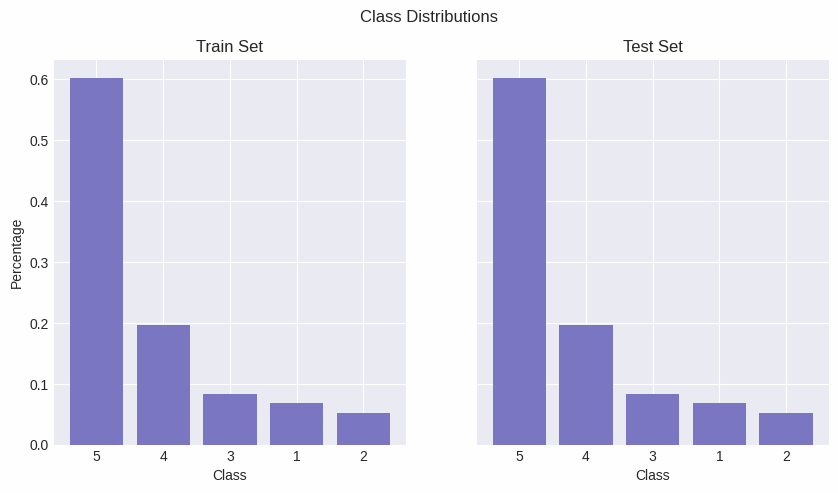

In [ ]:
# Get the value counts of our train and test sets
y_train_vals = y_train.value_counts()
y_test_vals = y_test.value_counts()

# Plot the distributions to check if they match the original
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.bar(y_train_vals.index.astype(str), y_train_vals.values/sum(y_train_vals.values))
ax2.bar(y_test_vals.index.astype(str), y_test_vals.values/sum(y_test_vals.values))
plt.suptitle("Class Distributions")
ax1.set_title("Train Set")
ax1.set_xlabel("Class")
ax1.set_ylabel("Percentage")
ax2.set_title("Test Set")
ax2.set_xlabel("Class")
plt.show()

This ensured that the train-test split maintained the same distribution as the original dataset.

#### Bag of Words Vectorizer
I will put my dataset through various versions of a CountVectorizer to see which yields the best results. First, I will start off with a standard one of simple English stop words and max the features at 500.

In [ ]:
#words aside from stop words to ignore
MY_STOP_WORDS = stopwords.words('english')
GENERIC_WORDS = ["book" , "author" , "read" , "character" , "story" , "page" , "write" , "series" , "review"]
MY_STOP_WORDS.extend(GENERIC_WORDS)

In [ ]:
working_cv = CountVectorizer(stop_words=MY_STOP_WORDS, min_df=10, max_features=1000)
working_cv.fit(X_train['review'])
X_train_transformed = working_cv.transform(X_train['review'])
X_test_transformed = working_cv.transform(X_test['review'])
X_test_transformed.shape
#cell takes 12 mins

(594861, 1000)

In [ ]:
#visualizing most common  wds

word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=working_cv.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()

In [ ]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.6020859281145655
Test score: 0.6026428396772353


Although 65% may seem low, this is simply a baseline score. There was no hyperoptimization or customization done. From the simple logistic regression, here is a viualization of the top words with positive sentiment:

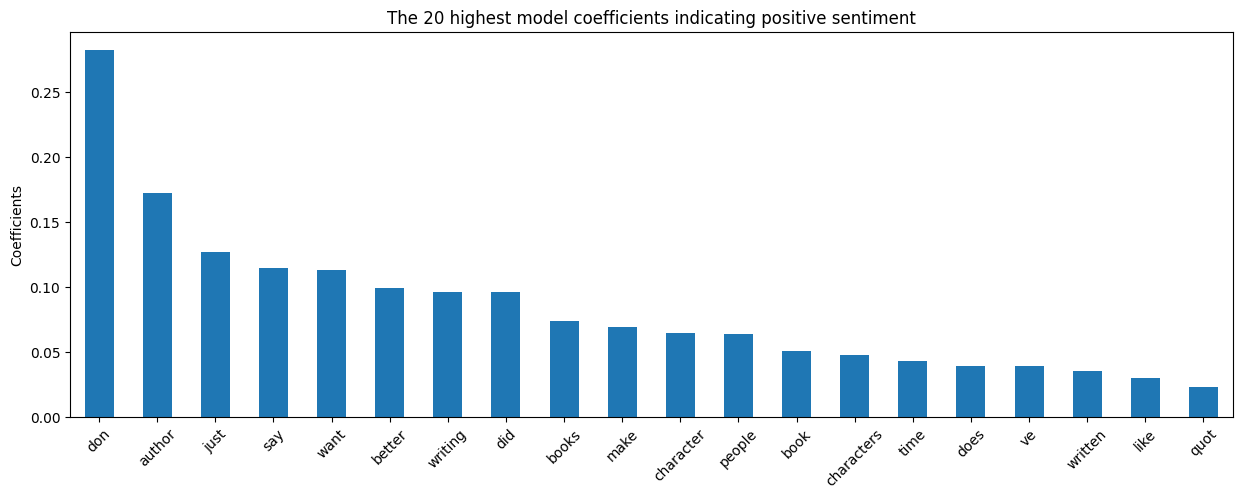

In [ ]:
#visualizing positive sentiment
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=working_cv.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()


The words do not seem to have positive sentiment, but rather the opposite. It seems I have misinterpreted my input.

#### Building a Custom Tokenizer

Next, I will attempt to create a custom tokenizer to best fit and optimize the model.

In [8]:
#words aside from stop words to ignore
MY_STOP_WORDS = stopwords.words('english')
GENERIC_WORDS = ["book" , "author" , "read" , "character" , "story" , "page" , "write" , "series" , "review"]
MY_STOP_WORDS.extend(GENERIC_WORDS)

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []

    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in MY_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [ ]:
# MY_STOP_WORDS

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
# sanity check
sentence = "Can you believe that: his (dog) like, read my book!"
my_tokenizer(sentence)

['believ', 'dog', 'like']

The words on my added stop list seem to be removed as well! This seems like a good start. I will put this tokenizer to the test.

In [ ]:
custom_cv = CountVectorizer(min_df =5,
                            max_features= 1000,
                            tokenizer=my_tokenizer)
custom_cv.fit(X_train['review'])

X_train_custom_transformed = custom_cv.transform(X_train['review'])
X_test_custom_transformed = custom_cv.transform(X_test['review'])

X_train_custom_transformed.shape

(1992782, 1000)

In [ ]:
X_train_custom_transformed

<10x10 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [ ]:
word_counts = pd.DataFrame(
    {"counts": X_train_custom_transformed.toarray().sum(axis=0)},
    index=custom_cv.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Fitting a model
logreg_for_custom_cv = LogisticRegression(C = 0.1)
logreg_for_custom_cv.fit(X_train_custom_transformed, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_custom_transformed, y_train)}")
print(f"Test score: {logreg.score(X_test_custom_transformed, y_test)}")

#### TF-IDF Version

In [36]:
tfidf = TfidfVectorizer(min_df =2,
                        max_features=1000,
                        tokenizer=my_tokenizer
                        )
X_train_transformed_tfidf = tfidf.fit_transform (X_train.review)

# X_train_transformed_tfidf = tfidf.transform(X_train.review)
X_test_transformed_tfidf = tfidf.transform(X_test.review)

X_train_transformed_tfidf.shape
#cell takes 10 mins

(75000, 1000)

In [32]:
print(tfidf.get_feature_names_out()[800:900])


['ship' 'short' 'show' 'side' 'similar' 'simpl' 'simpli' 'sinc' 'singl'
 'sister' 'sit' 'situat' 'skill' 'slow' 'small' 'smith' 'social' 'societi'
 'someon' 'someth' 'sometim' 'somewhat' 'son' 'soon' 'sort' 'soul' 'sound'
 'sourc' 'south' 'space' 'speak' 'special' 'specif' 'spend' 'spent'
 'spirit' 'spiritu' 'stand' 'standard' 'star' 'start' 'state' 'stay'
 'step' 'still' 'stop' 'stori' 'strang' 'strength' 'strong' 'structur'
 'struggl' 'student' 'studi' 'stuff' 'style' 'subject' 'success' 'suffer'
 'suggest' 'summer' 'support' 'suppos' 'sure' 'surpris' 'surviv' 'suspens'
 'symbol' 'system' 'take' 'taken' 'tale' 'talent' 'talk' 'teach' 'teacher'
 'techniqu' 'technolog' 'teenag' 'tell' 'ten' 'term' 'terribl' 'test'
 'text' 'thank' 'that' 'theme' 'theori' 'there' 'thing' 'think' 'third'
 'thoroughli' 'though' 'thought' 'three' 'throughout' 'thu' 'time']


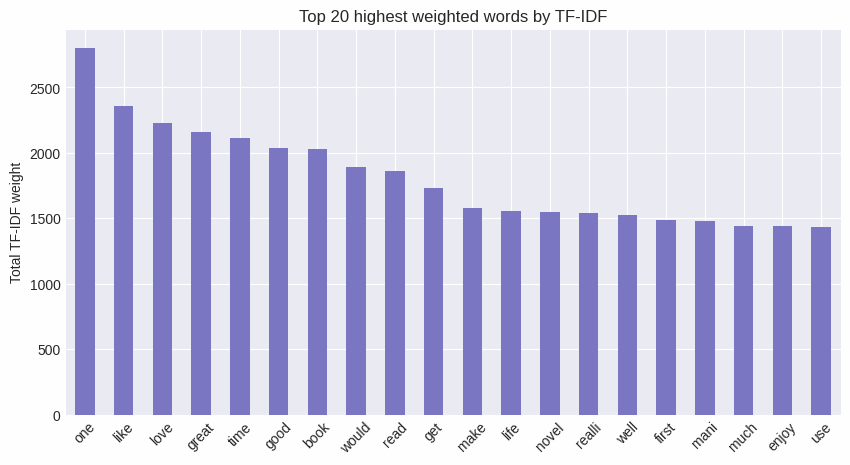

In [35]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed_tfidf.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(10, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Save vectorizer.vocabulary_
import pickle
pickle.dump(tfidf.vocabulary_,open("/content/drive/My Drive/tfidf_vocab_hundred_thousand_sample.pkl","wb"))

In [ ]:
# Pickle the tfidf object
with open('/content/drive/My Drive/tfidf.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [ ]:
# Pickle the tfidf fitted
with open('/content/drive/My Drive/tfidf_fit.pkl', 'wb') as file:
    pickle.dump(testing_pickle, file)

In [15]:
# Fitting a model, without cutom tokenizer
logreg_tfidf = LogisticRegression(C = 0.1)
logreg_tfidf.fit(X_train_transformed_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg_tfidf.score(X_train_transformed_tfidf, y_train)}")
print(f"Test score: {logreg_tfidf.score(X_test_transformed_tfidf, y_test)}")

Train score: 0.6425866666666666
Test score: 0.63828


In [ ]:
# Fitting a model wit custom tokenizer
logreg_tfidf_small_sample = LogisticRegression(C = 0.1)
logreg_tfidf_small_sample.fit(X_train_transformed_tfidf, y_train)

# Training and test score
print(f"Train score: {logreg_tfidf_small_sample.score(X_train_transformed_tfidf, y_train)}")
print(f"Test score: {logreg_tfidf_small_sample.score(X_test_transformed_tfidf, y_test)}")

Train score: 0.6425866666666666
Test score: 0.63828


# BERT
This [link](https://medium.com/@manindersingh120996/accelerate-your-text-data-analysis-with-custom-bert-word-embeddings-and-tensorflow-45590cf9c54)

In [ ]:
#importing libraries for BERT text embedding
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#load data, and encode with tensor tokenizer
text_data = X_train.review

encoded_data = tokenizer.batch_encode_plus(text_data,
                                           add_special_tokens=True,
                                           return_attention_mask=True,
                                           return_token_type_ids=False,
                                           pad_to_max_length=True
                                           )
# 30 secs

Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# convert to tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': encoded_data['input_ids'],
                                               'attention_mask': encoded_data['attention_mask']},
                                              np.zeros(len(encoded_data['input_ids']))))

In [ ]:
type(dataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model

input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
bert_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]
embedding_layer = GlobalAveragePooling1D()(bert_output)
embedding_model = Model(inputs=[input_ids, attention_mask], outputs=embedding_layer)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

embedding_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.CosineSimilarity(), metrics=[tf.metrics.CosineSimilarity()])

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
embedding_model.fit(dataset.batch(32), epochs=10, callbacks=[early_stopping])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node model/tf_bert_model_1/bert/embeddings/Gather_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-95-d1338c53dc21>", line 6, in <cell line: 6>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1061, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 1088, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1061, in run_call_with_unpacked_inputs

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 780, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_tf_bert.py", line 215, in call

indices[0,4088] = 4088 is not in [0, 512)
	 [[{{node model/tf_bert_model_1/bert/embeddings/Gather_1}}]] [Op:__inference_train_function_42993]

# Bert V2

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#tokenizing the whole data set
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
    # from code source: `padding=True` will pad the examples with zeros to the size of the longest one in a batch,
    # and `truncation=True` will truncate the examples to the model's maximum context size.

# Tensor Flow V2

# Word2Vec Method
[link](https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673)

# Building the Recommender System

In [10]:
X_train_transformed_tfidf

<75000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2662738 stored elements in Compressed Sparse Row format>

In [ ]:
# Cosine Similarity
similarities = cosine_similarity(X_train_transformed_tfidf, dense_output=False)
# didn't work

In [ ]:
cos_similarity_tfidf = cosine_similarity(X_train_transformed_tfidf, dense_output=False)

In [ ]:
similarities.shape

In [22]:
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub("\d+", " ", text)

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)

    # Lowercase the text
    text = text.lower()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)

    return text
# this cleaning function found at https://www.kaggle.com/code/ahmedmoharm/sentiment-analysis-bert-pytorch

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
modeling_df['clean_review'] = modeling_df['review'].apply(lambda i: clean_text(i))

In [29]:
modeling_df.head(1)

,Id,Title,User_id,profileName,review_score,review_summary,review,authors,publishedDate,categories,clean_review
2476676,096406054X,Mouse Tales: A Behind-the-Ears Look at Disneyl...,A89Y6WZKEP069,Jewelz- Theo's Mom,2,Caution: You may lose a bit of the magic....,This is a very well written book about the inn...,David Koenig,2005.0,Biography & Autobiography,well written book inner working secret disneyl...


In [30]:
#export tokenized df, this will be the new working df
modeling_df.to_csv('tokenized_data.csv')
!cp tokenized_data.csv "/content/drive/My Drive/"

# Next Steps & "Productionalization"
If I were to improve this model, I would try and use all the data available to me via higher computing power. Also, to formally use this model as a product, the next step would be to "productionalize." In a future notebook, I will outline steps to create a simple web service for use.